# 학습목표
- 전이학습 개념을 이해하자
- VGG16 모델을 활용해보자

## 데이터 로드

In [3]:
# 작업 디렉토리 이동
%cd "./drive/MyDrive/Colab Notebooks/딥러닝 기초 25.07.11 (class 2)"

/content/drive/MyDrive/Colab Notebooks/딥러닝 기초 25.07.11 (class 2)


In [4]:
# 데이터로드
import numpy as np
from tqdm import tqdm # 반복문 작업의 진척률을 알려주는 도구
from tensorflow.keras.utils import image_dataset_from_directory # 폴더로부터 이미지를 읽어주는 도구

In [5]:
# 2. 데이터 로딩
train_data = image_dataset_from_directory(
  directory = "./data/animal", # 읽어들일 경로
  labels = "inferred", # 폴더명을 인식해서 사진마다 정답으로 붙여준다
  label_mode = "categorical", # 다중분류 정답 형태로 붙여줘라
  color_mode = 'rgb', # 컬러 색상체계로 읽어줘라
  image_size = (224,224) # 입력한 사진 크기에 맞춰 리사이징
)

Found 2500 files belonging to 5 classes.


In [7]:
# 훈련용 데이터가 저장될 리스트 생성
X_train = []
y_train = []

In [8]:
# 반복문을 이용해서 데이터(문제,정답) 읽기
for img, label in tqdm(train_data.as_numpy_iterator()) :
  X_train.append(img) # 32장씩 이미지를 리스트에 저장
  y_train.append(label) # 32개 정답데이터를 리스트에 저장

79it [00:15,  4.96it/s]


In [9]:
# 리스트에 담겨있는(32개씩 묶음) 데이터를 하나의 넘파이로 통합
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

In [10]:
# 데이터 모양 확인
X_train.shape, y_train.shape

((2500, 224, 224, 3), (2500, 5))

## 특성추출 방식
- 사전학습 모델의 분류기 부분을 제외하고 특성추출부를 활용한다
- 사용법은 단순하지만 특정도메인에 특화된 특성추출이 어려울 수 있다

In [11]:
# 특성추출기 import
from tensorflow.keras.applications import InceptionV3 # 사전학습모델
from tensorflow.keras.applications.inception_v3 import preprocess_input # 0~255 -> -1~1

In [9]:
# 특성추출기 생성
imageEmbedding = InceptionV3(include_top=False, # 분류기를 제외한 특성추출부만 다운로드
                             weights = 'imagenet', # 이미지넷 대회 이미지를 활용한 가중치 적용
                             input_shape = (224,224,3), # 입력되는 이미지의 모양
                             pooling='avg')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# 이미지 픽셀값 전처리
X_train_preprocessed = preprocess_input(X_train)

In [12]:
# 이미지를 inceptionV3에 넣어서 특성추출하기
X_train_embedding = imageEmbedding.predict(X_train_preprocessed)

79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step


In [13]:
X_train_embedding.shape

(2500, 2048)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

In [22]:
# 모델설계
mlp_model = Sequential()
# 입력층
mlp_model.add(InputLayer(shape=(2048,)))
# 중간층
mlp_model.add(Dense(256, activation='relu'))
# 출력층
mlp_model.add(Dense(5, activation='softmax'))

In [23]:
# 학습방법 설정
mlp_model.compile(loss="categorical_crossentropy",
                  optimizer="Adam",
                  metrics=['accuracy'])

In [24]:
# 모델학습
h = mlp_model.fit(X_train_embedding,
                  y_train,
                  validation_split=0.2,
                  epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3595 - loss: 1.5116 - val_accuracy: 0.4040 - val_loss: 1.3420
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4868 - loss: 1.2521 - val_accuracy: 0.4700 - val_loss: 1.2964
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5368 - loss: 1.1451 - val_accuracy: 0.5080 - val_loss: 1.2845
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6171 - loss: 1.0364 - val_accuracy: 0.4760 - val_loss: 1.2876
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6240 - loss: 0.9966 - val_accuracy: 0.5200 - val_loss: 1.2270
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6671 - loss: 0.9085 - val_accuracy: 0.4900 - val_loss: 1.2940
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6756 - loss: 0.8866 - val_accuracy: 0.5160 - val_loss: 1.2709
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7025 - loss: 0.8222 - val_accuracy: 0.4900 - val_loss

In [32]:
# 특성추출부 붙이기
imageEmbedding.trainable = False # 특성추출기가 학습되지 않도록 설정

# 모델설계
mlp_model2 = Sequential()
# 입력층
mlp_model2.add(InputLayer(shape=(224,224,3)))
# 중간층
mlp_model2.add(imageEmbedding) # 특성추출부
mlp_model2.add(Dense(256, activation='relu'))
# 출력층
mlp_model2.add(Dense(5, activation='softmax'))

In [27]:
mlp_model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,613 (85.18 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [13]:
from tensorflow.keras.optimizers import Adam

In [33]:
# 학습방법 설정
mlp_model2.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

In [34]:
# 모델학습
h2 = mlp_model2.fit(X_train_preprocessed,
                  y_train,
                  validation_split=0.2,
                  epochs=100)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 566ms/step - accuracy: 0.2540 - loss: 1.5866 - val_accuracy: 0.4280 - val_loss: 1.4658
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.4480 - loss: 1.4157 - val_accuracy: 0.4420 - val_loss: 1.3836
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5044 - loss: 1.3158 - val_accuracy: 0.4520 - val_loss: 1.3532
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.5027 - loss: 1.2657 - val_accuracy: 0.4840 - val_loss: 1.3158
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5165 - loss: 1.2379 - val_accuracy: 0.4940 - val_loss: 1.3026
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5692 - loss: 1.1736 - val_accuracy: 0.5180 - val_loss: 1.2776
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5773 - loss: 1.1574 - val_accuracy: 0.5220 - val_loss: 1.2632
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5701 - loss: 1.1349 - val_accura

## 파인튜닝 방식
- 특성추출부의 일부를 재학습시키는 방식
- 도메인에 대한 특성추출을 학습시키기 때문에 성능개선의 여지가 있다

In [14]:
# VGG16 모델 불러오기
from tensorflow.keras.applications import VGG16
import tensorflow.keras.applications.vgg16

In [15]:
# vgg16용 이미지 전처리
X_train_preprocessed_for_vgg = tensorflow.keras.applications.vgg16.preprocess_input(X_train)

In [16]:
X_train_preprocessed_for_vgg

array([[[[ -21.224716  ,  -43.064713  ,  -39.965714  ],
         [  -1.8318634 ,  -25.707573  ,  -23.626427  ],
         [  -5.2693634 ,  -31.10936   ,  -30.01036   ],
         ...,
         [ -31.394386  ,  -94.23438   ,   34.561028  ],
         [ -35.90336   ,  -98.743355  ,   28.355644  ],
         [ -38.769356  , -100.779     ,   24.659294  ]],

        [[ -24.439484  ,  -46.1371    ,  -43.46524   ],
         [  -3.0683136 ,  -26.531868  ,  -25.687172  ],
         [  -3.1336746 ,  -28.973671  ,  -27.874672  ],
         ...,
         [ -33.200356  ,  -96.04035   ,   33.00985   ],
         [ -38.00905   , -100.849045  ,   27.104195  ],
         [ -41.14483   , -103.15447   ,   22.283821  ]],

        [[ -20.53801   ,  -41.476227  ,  -40.95838   ],
         [   3.3103561 ,  -19.342133  ,  -20.198494  ],
         [   8.433929  ,  -16.673927  ,  -17.039215  ],
         ...,
         [ -32.81404   ,  -95.65404   ,   33.44497   ],
         [ -37.68013   , -100.52013   ,   27.596703  ],
  

In [17]:
# 모델생성
vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [18]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 파인튜닝할 출력부에 가까운 레이어 이름 지정
layer_name = 'block5_conv3'

In [20]:
# 학습 여부 지정
for layer in vgg16.layers:
  if layer.name == layer_name:
    continue
  layer.trainable = False # 학습이 안되도록 동결

In [21]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [22]:
from tensorflow.keras.layers import Flatten

In [23]:
# 모델설계
mlp_model3 = Sequential()
# 입력층
mlp_model3.add(InputLayer(shape=(224,224,3)))
# 중간층
mlp_model3.add(vgg16) # 특성추출부
mlp_model3.add(Flatten())
mlp_model3.add(Dense(128, activation='relu'))
mlp_model3.add(Dense(256, activation='relu'))
mlp_model3.add(Dense(128, activation='relu'))
mlp_model3.add(Dense(64, activation='relu'))
# 출력층
mlp_model3.add(Dense(5, activation='softmax'))

In [24]:
# 학습방법 설정
mlp_model3.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

In [25]:
# 모델학습
h3 = mlp_model3.fit(X_train_preprocessed_for_vgg,
                  y_train,
                  validation_split=0.2,
                  epochs=100)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 669ms/step - accuracy: 0.6210 - loss: 1.7776 - val_accuracy: 0.9160 - val_loss: 0.2884
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.9906 - loss: 0.0540 - val_accuracy: 0.9280 - val_loss: 0.2133
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.9989 - loss: 0.0049 - val_accuracy: 0.9340 - val_loss: 0.2085
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9360 - val_loss: 0.1991
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 1.0000 - loss: 8.0181e-04 - val_accuracy: 0.9400 - val_loss: 0.1938
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 1.0000 - loss: 5.2727e-04 - val_accuracy: 0.9400 - val_loss: 0.1918
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 1.0000 - loss: 4.3876e-04 - val_accuracy: 0.9400 - val_loss: 0.1900
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 1.0000 - los

KeyboardInterrupt: 

## 종합실습
- Food 101 데이터셋 활용 음식분류모델 만들기
- 음식 선택 (2가지, 3가지, 4가지 등 자유롭게)
- 전이학습 방식활용 (특성추출방식, 파인튜닝방식)
- (옵션) 모델링시 모델자동저장,조기학습중단 callback 활용


### 실습시간 종료 후 작성된 노트북파일 과제제출 섹션에 업로드하기

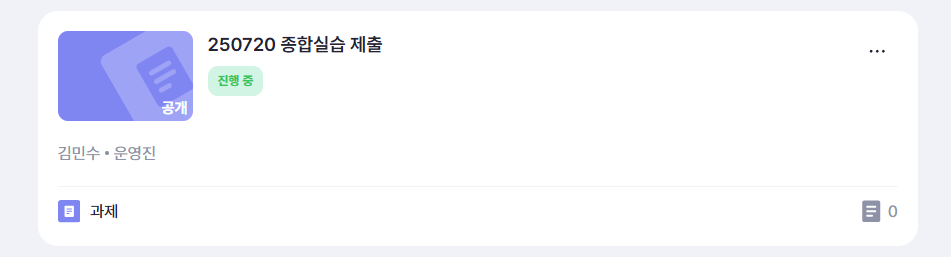